#How did the COVID-19 pandemic impact ABC Company’s parcel business?


COVID Growth Impact Summary:

Period     growth_label  Customer Count  Total Volume  Estimated Revenue ($)
1           High Growth             941      58732836           1.292122e+09
0             Declining              88         87235           1.919170e+06
3                   New               7         23180           5.099600e+05
2       Moderate Growth              10         13422           2.952840e+05
4               Unknown              15             0           0.000000e+00


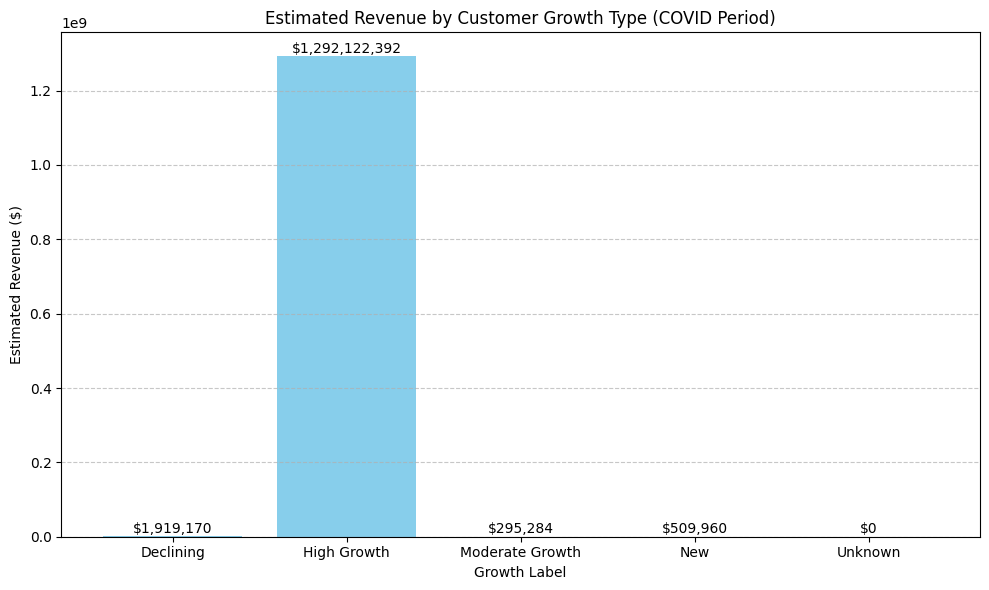

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Import the dataset
df = pd.read_csv("COVID_Parcel_Business.csv")

# Step 2: Create a 'Date' column using year and week
df['Date'] = pd.to_datetime(df['THE_YEAR'].astype(str) + '-1', format='%Y-%w') + pd.to_timedelta((df['THE_WEEK'] - 1) * 7, unit='D')

# Step 3: Classify periods
def classify_period(row):
    if row['THE_YEAR'] == 2019 and row['THE_WEEK'] <= 15:
        return 'pre_covid_2019'
    elif row['THE_YEAR'] == 2020 and row['THE_WEEK'] <= 15:
        return 'pre_covid_2020'
    elif row['THE_YEAR'] == 2020 and row['THE_WEEK'] > 15:
        return 'covid_period_2020'
    else:
        return 'other'

df['Period'] = df.apply(classify_period, axis=1)

# Step 4: Compute ISGR (Industry Standard Growth Rate)
pre_covid_2019_volume = df[df['Period'] == 'pre_covid_2019']['VOLUME'].sum()
pre_covid_2020_volume = df[df['Period'] == 'pre_covid_2020']['VOLUME'].sum()
ISGR = ((pre_covid_2020_volume - pre_covid_2019_volume) / pre_covid_2019_volume) * 100

# Step 5: Aggregate parcel volume by customer and period
volume_by_customer = df.groupby(['FakeCustomerID', 'Period'])['VOLUME'].sum().unstack(fill_value=0).reset_index()

# Step 6: Calculate customer growth rate
volume_by_customer['growth_rate'] = np.where(
    volume_by_customer['pre_covid_2020'] == 0,
    np.nan,
    ((volume_by_customer['covid_period_2020'] - volume_by_customer['pre_covid_2020']) / volume_by_customer['pre_covid_2020']) * 100
)

# Step 7: Assign growth labels
def growth_label(row):
    if row['pre_covid_2020'] == 0 and row['covid_period_2020'] > 0:
        return 'New'
    elif pd.isna(row['growth_rate']):
        return 'Unknown'
    elif row['growth_rate'] > ISGR:
        return 'High Growth'
    elif row['growth_rate'] > 0:
        return 'Moderate Growth'
    elif row['growth_rate'] == 0:
        return 'Stable'
    elif row['growth_rate'] < 0:
        return 'Declining'
    else:
        return 'Unknown'

volume_by_customer['growth_label'] = volume_by_customer.apply(growth_label, axis=1)

# Step 8: Identify lost customers
volume_by_customer['lost'] = (
    ((volume_by_customer.get('pre_covid_2019', 0) > 0) | (volume_by_customer.get('pre_covid_2020', 0) > 0)) &
    (volume_by_customer.get('covid_period_2020', 0) == 0)
)

# Step 9: Estimate COVID-period revenue
base_cost = 22.00
volume_by_customer['revenue_estimate'] = volume_by_customer['covid_period_2020'] * base_cost

# Step 10: Summarize by growth label
growth_summary = volume_by_customer.groupby('growth_label').agg({
    'FakeCustomerID': 'count',
    'covid_period_2020': 'sum',
    'revenue_estimate': 'sum'
}).rename(columns={
    'FakeCustomerID': 'Customer Count',
    'covid_period_2020': 'Total Volume',
    'revenue_estimate': 'Estimated Revenue ($)'
}).reset_index()

# Step 11: Display the summary
print("\nCOVID Growth Impact Summary:\n")
print(growth_summary.sort_values(by='Estimated Revenue ($)', ascending=False))

# Step 12: Plot revenue impact
plt.figure(figsize=(10, 6))
bars = plt.bar(growth_summary['growth_label'], growth_summary['Estimated Revenue ($)'], color='skyblue')
plt.title("Estimated Revenue by Customer Growth Type (COVID Period)")
plt.xlabel("Growth Label")
plt.ylabel("Estimated Revenue ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1e6, f"${yval:,.0f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


#•	When were customer volumes first impacted by COVID-19?

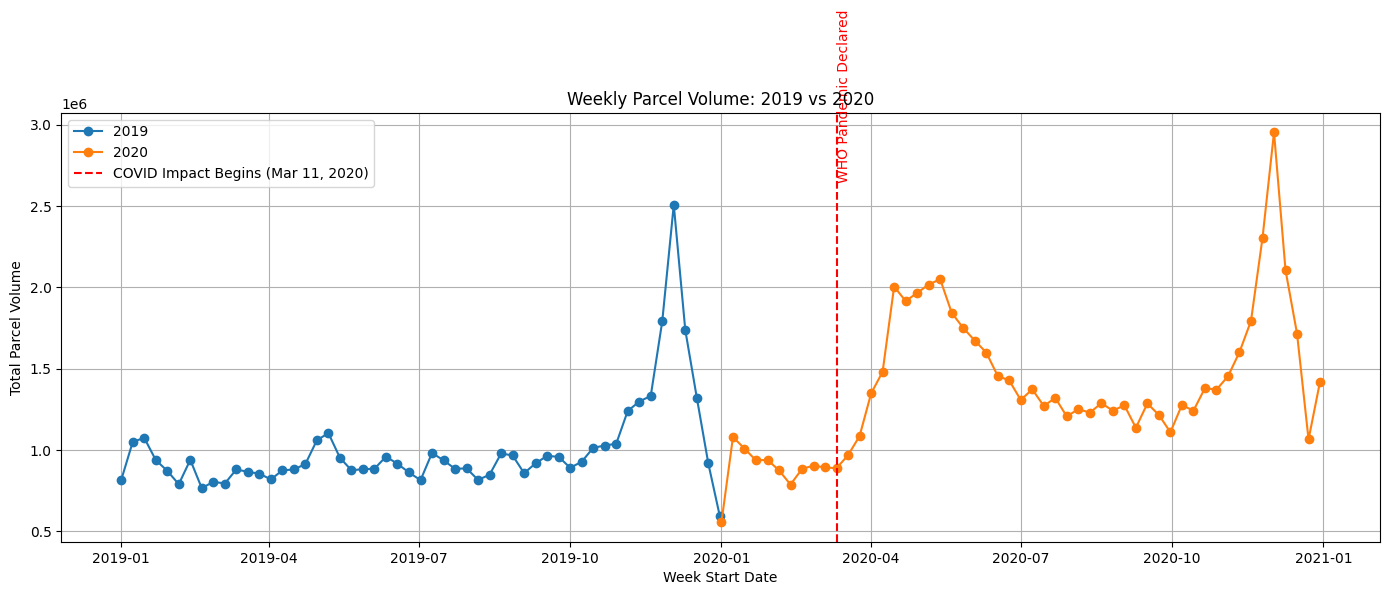

In [19]:
# Aggregate total volume by week and year
weekly_volume = df.groupby(['THE_YEAR', 'THE_WEEK'])['VOLUME'].sum().reset_index()

# Estimate date from year and week
weekly_volume['WeekStart'] = pd.to_datetime(weekly_volume['THE_YEAR'].astype(str) + '-1', format='%Y-%w') \
                             + pd.to_timedelta((weekly_volume['THE_WEEK'] - 1) * 7, unit='D')

# Separate 2019 and 2020 data for visual comparison
volume_2019 = weekly_volume[weekly_volume['THE_YEAR'] == 2019]
volume_2020 = weekly_volume[weekly_volume['THE_YEAR'] == 2020]

# Plot the trend
plt.figure(figsize=(14, 6))
plt.plot(volume_2019['WeekStart'], volume_2019['VOLUME'], label='2019', marker='o')
plt.plot(volume_2020['WeekStart'], volume_2020['VOLUME'], label='2020', marker='o')

# Add annotation for COVID onset (WHO pandemic declaration)
covid_start = pd.to_datetime("2020-03-11")
plt.axvline(covid_start, color='red', linestyle='--', label='COVID Impact Begins (Mar 11, 2020)')
plt.text(covid_start, weekly_volume['VOLUME'].max()*0.9, "WHO Pandemic Declared", rotation=90, color='red')

plt.title("Weekly Parcel Volume: 2019 vs 2020")
plt.xlabel("Week Start Date")
plt.ylabel("Total Parcel Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



#What events within the COVID timeline may have contributed to the change?

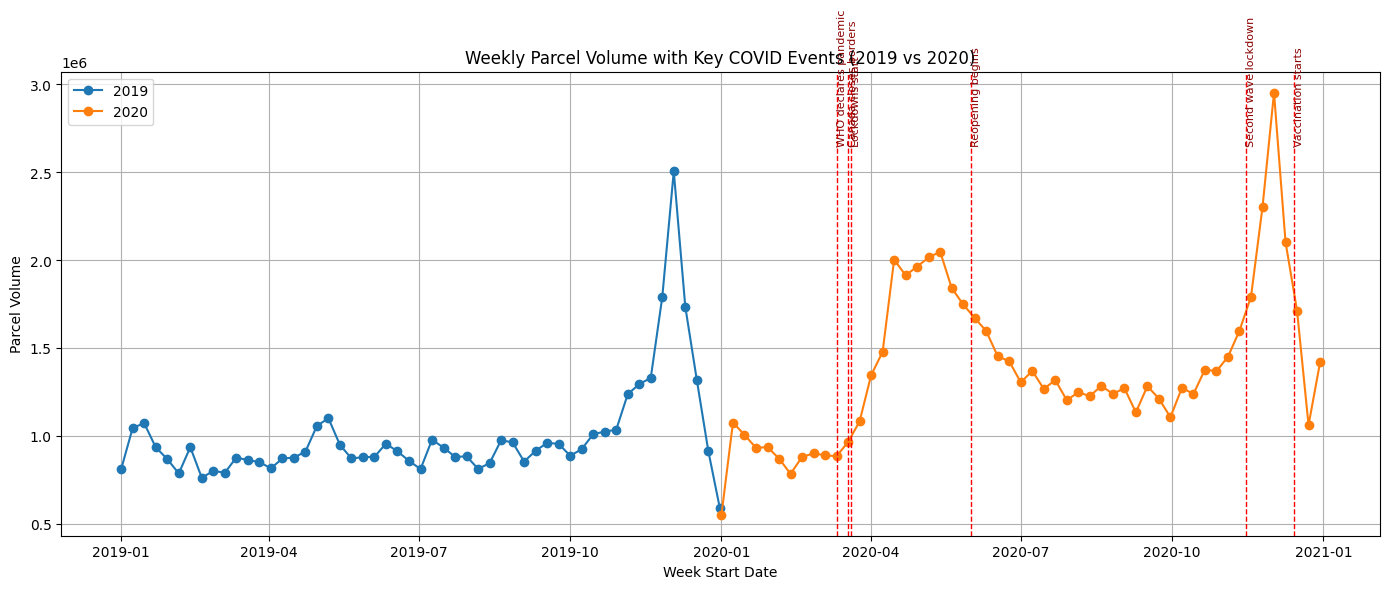

In [20]:
# Define COVID timeline events
events = [
    ("WHO declares pandemic", "2020-03-11"),
    ("Canada closes borders", "2020-03-18"),
    ("Lockdowns start", "2020-03-20"),
    ("Reopening begins", "2020-06-01"),
    ("Second wave lockdown", "2020-11-15"),
    ("Vaccination starts", "2020-12-14")
]

# Plot again with annotations
plt.figure(figsize=(14, 6))
plt.plot(volume_2019['WeekStart'], volume_2019['VOLUME'], label='2019', marker='o')
plt.plot(volume_2020['WeekStart'], volume_2020['VOLUME'], label='2020', marker='o')

for event, date in events:
    date_obj = pd.to_datetime(date)
    plt.axvline(x=date_obj, color='red', linestyle='--', linewidth=1)
    plt.text(date_obj, weekly_volume['VOLUME'].max()*0.9, event, rotation=90, fontsize=8, color='darkred')

plt.title("Weekly Parcel Volume with Key COVID Events (2019 vs 2020)")
plt.xlabel("Week Start Date")
plt.ylabel("Parcel Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#•	How did COVID-19 impact peak season in 2020?

In [21]:
# Define peak season ranges
peak_2019_start = pd.to_datetime("2019-11-04")
peak_2019_end = pd.to_datetime("2020-01-20")
peak_2020_start = pd.to_datetime("2020-11-02")
peak_2020_end = pd.to_datetime("2021-01-17")

# Filter data for each peak season
peak_2019_df = df[(df['Date'] >= peak_2019_start) & (df['Date'] <= peak_2019_end)]
peak_2020_df = df[(df['Date'] >= peak_2020_start) & (df['Date'] <= peak_2020_end)]

# Summarize total volume and revenue
def summarize_peak(df_peak, label):
    total_volume = df_peak['VOLUME'].sum()
    total_revenue = total_volume * 22.00  # assuming base cost per parcel
    return {
        'Peak Season': label,
        'Total Volume': total_volume,
        'Estimated Revenue ($)': total_revenue
    }

summary_2019 = summarize_peak(peak_2019_df, '2019-2020')
summary_2020 = summarize_peak(peak_2020_df, '2020-2021')

peak_season_summary = pd.DataFrame([summary_2019, summary_2020])
peak_season_summary


,Peak Season,Total Volume,Estimated Revenue ($)
0,2019-2020,15372691,338199202.0
1,2020-2021,19442907,427743954.0


#•	How has COVID affected companies in the different customer groups (Enterprise, Large, etc.)?

In [22]:
# Step 1: Pre-COVID 2020 volume per customer (Weeks 1–15)
pre_covid_2020 = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] <= 15)]
pre_covid_volume = pre_covid_2020.groupby('FakeCustomerID')['VOLUME'].sum().reset_index()
pre_covid_volume.columns = ['FakeCustomerID', 'Pre_COVID_2020_Volume']

# Step 2: Simulate customer groups based on volume
def classify_customer(volume):
    if volume >= 10000:
        return 'Enterprise'
    elif volume >= 1000:
        return 'Large'
    elif volume >= 100:
        return 'Medium'
    else:
        return 'Small'

pre_covid_volume['Customer_Group'] = pre_covid_volume['Pre_COVID_2020_Volume'].apply(classify_customer)

# Step 3: Merge group info back to main df
df = df.merge(pre_covid_volume[['FakeCustomerID', 'Customer_Group']], on='FakeCustomerID', how='left')

# Step 4: Filter COVID period (Weeks 16–53, 2020)
covid_df = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] > 15)]

# Step 5: Aggregate by customer group
group_summary = covid_df.groupby('Customer_Group').agg({
    'VOLUME': 'sum',
    'FakeCustomerID': 'nunique'
}).rename(columns={
    'VOLUME': 'Total COVID Volume',
    'FakeCustomerID': 'Unique Customers'
}).reset_index()

# Step 6: Estimate revenue
group_summary['Estimated Revenue ($)'] = group_summary['Total COVID Volume'] * 22.00
group_summary.sort_values(by='Estimated Revenue ($)', ascending=False, inplace=True)

group_summary


,Customer_Group,Total COVID Volume,Unique Customers,Estimated Revenue ($)
0,Enterprise,53710276,87,1.181626e+09
1,Large,3897272,374,8.573998e+07
2,Medium,1163118,542,2.558860e+07
3,Small,62827,21,1.382194e+06


#•	What percent of each customer group is growing, moderately growing, and declining during the COVID observation period?

In [23]:
# Reuse the volume_by_customer dataframe and merge it with the customer group info
volume_by_customer_grouped = volume_by_customer.merge(
    pre_covid_volume[['FakeCustomerID', 'Customer_Group']],
    on='FakeCustomerID',
    how='left'
)

# Remove customers without a defined group
volume_by_customer_grouped = volume_by_customer_grouped.dropna(subset=['Customer_Group'])

# Group by Customer_Group and Growth_Label
group_growth_distribution = volume_by_customer_grouped.groupby(
    ['Customer_Group', 'growth_label']
)['FakeCustomerID'].count().reset_index()

# Pivot for easier percentage calculation
pivot_dist = group_growth_distribution.pivot(index='Customer_Group', columns='growth_label', values='FakeCustomerID').fillna(0)

# Calculate row-wise percentage
pivot_dist_percent = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Round and reset for display
pivot_dist_percent = pivot_dist_percent.round(2).reset_index()
pivot_dist_percent


growth_label,Customer_Group,Declining,High Growth,Moderate Growth
0,Enterprise,5.75,94.25,0.00
1,Large,6.65,91.76,1.60
2,Medium,8.93,90.35,0.73
3,Small,33.33,66.67,0.00


#•	What percent of each customer group are new customers during the COVID observation period?

In [24]:
# Count new customers by group
new_customers = volume_by_customer_grouped[volume_by_customer_grouped['growth_label'] == 'New']

# Total customers per group
total_customers_per_group = volume_by_customer_grouped.groupby('Customer_Group')['FakeCustomerID'].count().reset_index()
total_customers_per_group.columns = ['Customer_Group', 'Total_Customers']

# Merge with new customer counts
new_counts = new_customers.groupby('Customer_Group')['FakeCustomerID'].count().reset_index()
new_counts.columns = ['Customer_Group', 'New_Customers']

# Combine and compute percentages
new_percent_summary = pd.merge(total_customers_per_group, new_counts, on='Customer_Group', how='left').fillna(0)
new_percent_summary['New Customer %'] = (new_percent_summary['New_Customers'] / new_percent_summary['Total_Customers']) * 100
new_percent_summary = new_percent_summary.round(2)

new_percent_summary


,Customer_Group,Total_Customers,New_Customers,New Customer %
0,Enterprise,87,0.0,0.0
1,Large,376,0.0,0.0
2,Medium,549,0.0,0.0
3,Small,27,0.0,0.0


#•	What percent of 2019 customers in each group did we lose during the COVID observation period?

In [25]:
# Step 1: Identify customers active in 2019 (any week)
active_2019 = df[df['THE_YEAR'] == 2019]['FakeCustomerID'].unique()

# Step 2: Identify customers active during COVID (Week 16+ of 2020)
active_covid = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] > 15)]['FakeCustomerID'].unique()

# Step 3: Lost customers = Active in 2019 but NOT active during COVID
lost_customer_ids = set(active_2019) - set(active_covid)

# Step 4: Get group info for lost customers
lost_customers_grouped = pre_covid_volume[pre_covid_volume['FakeCustomerID'].isin(lost_customer_ids)]

# Count lost customers per group
lost_counts = lost_customers_grouped.groupby('Customer_Group')['FakeCustomerID'].nunique().reset_index()
lost_counts.columns = ['Customer_Group', 'Lost_Customers']

# Step 5: Total 2019 customers per group (from pre_covid_volume)
total_2019_group = pre_covid_volume.groupby('Customer_Group')['FakeCustomerID'].nunique().reset_index()
total_2019_group.columns = ['Customer_Group', 'Total_2019_Customers']

# Step 6: Merge and calculate percent lost
lost_summary = pd.merge(total_2019_group, lost_counts, on='Customer_Group', how='left').fillna(0)
lost_summary['Lost Customer %'] = (lost_summary['Lost_Customers'] / lost_summary['Total_2019_Customers']) * 100
lost_summary = lost_summary.round(2)

lost_summary


,Customer_Group,Total_2019_Customers,Lost_Customers,Lost Customer %
0,Enterprise,87,0.0,0.00
1,Large,376,2.0,0.53
2,Medium,549,7.0,1.28
3,Small,27,6.0,22.22


#What was the overall impact of COVID on volumes and revenue by customer group?

In [26]:
# Step 1: COVID period data (Week 16+ of 2020)
covid_period_df = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] > 15)]

# Step 2: Pre-COVID period data (Weeks 1–15 of 2020)
pre_covid_period_df = df[(df['THE_YEAR'] == 2020) & (df['THE_WEEK'] <= 15)]

# Step 3: Aggregate pre- and covid-period volume by customer group
pre_covid_grouped = pre_covid_period_df.groupby('Customer_Group')['VOLUME'].sum().reset_index()
pre_covid_grouped.columns = ['Customer_Group', 'Pre_COVID_Volume']

covid_grouped = covid_period_df.groupby('Customer_Group')['VOLUME'].sum().reset_index()
covid_grouped.columns = ['Customer_Group', 'COVID_Volume']

# Step 4: Merge and compute revenue
impact_summary = pd.merge(pre_covid_grouped, covid_grouped, on='Customer_Group', how='outer').fillna(0)
impact_summary['Pre_COVID_Revenue ($)'] = impact_summary['Pre_COVID_Volume'] * 22.00
impact_summary['COVID_Revenue ($)'] = impact_summary['COVID_Volume'] * 22.00
impact_summary['Volume_Change (%)'] = ((impact_summary['COVID_Volume'] - impact_summary['Pre_COVID_Volume']) / impact_summary['Pre_COVID_Volume']) * 100
impact_summary['Revenue_Change ($)'] = impact_summary['COVID_Revenue ($)'] - impact_summary['Pre_COVID_Revenue ($)']

impact_summary = impact_summary.round(2)
impact_summary


,Customer_Group,Pre_COVID_Volume,COVID_Volume,Pre_COVID_Revenue ($),COVID_Revenue ($),Volume_Change (%),Revenue_Change ($)
0,Enterprise,13245903,53710276,291409866.0,1.181626e+09,305.49,890216206.0
1,Large,1084686,3897272,23863092.0,8.573998e+07,259.30,61876892.0
2,Medium,287299,1163118,6320578.0,2.558860e+07,304.85,19268018.0
3,Small,1129,62827,24838.0,1.382194e+06,5464.84,1357356.0
